In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import pandas as pd
import networkx as nx
import numpy as np
import csv
import matplotlib.pyplot as plt

# Step 1: Load Data
transactions_df = pd.read_csv('/content/drive/MyDrive/Trust Rank files/Payments.csv')
bad_nodes_df = pd.read_csv('/content/drive/MyDrive/Trust Rank files/bad_sender.csv')

Count of nodes with no outlinks: 96
Transition matrix has been saved to 'Transition_Matrix.csv'.
Total number of unique nodes: 799


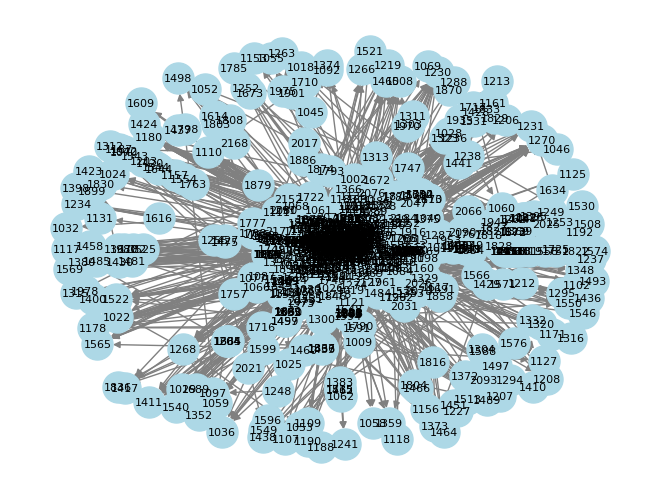

In [26]:
class Node:
    def __init__(self, node_id):
        self.id = node_id
        self.adjacent = {}  # Dictionary to hold transaction amounts to adjacent nodes

class Graph:

    def __init__(self):
        self.nodes = {}  # Dictionary to hold nodes indexed by node IDs
        self.bad_nodes = set()  # Set to hold bad nodes

    def add_node(self, node_id):
        if node_id not in self.nodes:
            self.nodes[node_id] = Node(node_id)

    def number_of_nodes(self):
        return len(self.nodes)  # Return the number of nodes in the graph

    def add_edge(self, from_node, to_node, amount):
        if from_node == to_node:
            print(f"Skipping self-loop at node {from_node}")
            return
        self.add_node(from_node)
        self.add_node(to_node)
        # Summing transaction amounts for each pair of nodes
        if to_node in self.nodes[from_node].adjacent:
            self.nodes[from_node].adjacent[to_node] += amount
        else:
            self.nodes[from_node].adjacent[to_node] = amount

    def display(self):
        for node_id, node in self.nodes.items():
            print(f"Node {node_id} has edges to: {node.adjacent}")

    def generate_transition_matrix(self):
        nodes = sorted(self.nodes.keys())
        transition_matrix = pd.DataFrame(0, index=nodes, columns=nodes, dtype=float)

        for sender in nodes:
            sender_node = self.nodes[sender]
            total_out_weight = sum(sender_node.adjacent.values())

            if total_out_weight > 0:
                for receiver, weight in sender_node.adjacent.items():
                    transition_matrix.at[sender, receiver] = weight / total_out_weight
            else:
                # Handling dangling nodes by redirecting to bad nodes if specified
                if self.bad_nodes and sender not in self.bad_nodes:
                    for bad_node in self.bad_nodes:
                        transition_matrix.at[sender, bad_node] = 1 / len(self.bad_nodes)
                else:
                    # If there are no bad nodes, distribute uniformly across all nodes
                    transition_matrix.loc[sender] = 1 / len(nodes)

        return transition_matrix

    def read_edges_from_csv(self, file_path):
        with open(file_path, mode='r') as file:
            csv_reader = csv.DictReader(file)
            for row in csv_reader:
                from_node = int(row['Sender'])
                to_node = int(row['Receiver'])
                amount = float(row['Amount'])
                self.add_edge(from_node, to_node, amount)

    def read_bad_nodes(self, file_path):
        with open(file_path, mode='r') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header if there is one
            self.bad_nodes.update(int(row[0]) for row in reader)
    def display_graph(self):
        G = nx.DiGraph()
        for from_node, node in self.nodes.items():
            G.add_node(from_node)
            for to_node, amount in node.adjacent.items():
                G.add_node(to_node)
                G.add_edge(from_node, to_node, weight=amount)
        nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=8)
        plt.show()

    def display_number_of_nodes(self):
        print(f"Total number of unique nodes: {self.number_of_nodes()}")
    def count_nodes_with_no_outlinks(self):
        no_outlink_nodes_count = sum(1 for node_id, node in self.nodes.items() if not node.adjacent)
        return no_outlink_nodes_count
# Example usage
g = Graph()
csv_file_path = '/content/drive/MyDrive/Trust Rank files/Payments.csv'
bad_nodes_path = '/content/drive/MyDrive/Trust Rank files/bad_sender.csv'
g.read_edges_from_csv(csv_file_path)
g.read_bad_nodes(bad_nodes_path)
transition_matrix = g.generate_transition_matrix()
transition_matrix.to_csv('Transition_Matrix.csv')
no_outlink_nodes_count = g.count_nodes_with_no_outlinks()
print("Count of nodes with no outlinks:", no_outlink_nodes_count)
print("Transition matrix has been saved to 'Transition_Matrix.csv'.")
g.display_number_of_nodes()
g.display_graph()

In [27]:
def MistrustRank(T, N, alpha, MB, bad_senders, tolerance=1e-5):
    # Initialize mistrust scores: High for bad senders, low (zero) for others
    d = np.zeros(N)
    nodes = list(g.nodes.keys())
    for node in nodes:
        if node in bad_senders:
            index = nodes.index(node)
            d[index] = 1 # High initial mistrust for bad senders

    # Normalize the mistrust vector to make it a proper probability distribution
    d /= np.sum(d)  # Ensure the sum of the scores equals 1

    # Compute MistrustRank scores using a modified PageRank formula
    mistrust_scores = d.copy()
    for iteration in range(MB):
        new_mistrust_scores = alpha * np.dot(T, mistrust_scores) + (1 - alpha) * d
        # Check for convergence
        if np.linalg.norm(new_mistrust_scores - mistrust_scores, 1) < tolerance:
            print(f"Converged after {iteration + 1} iterations.")
            break
        mistrust_scores = new_mistrust_scores

    return mistrust_scores

# Example usage:
# Assume G is your graph, created from transactions DataFrame
#G = nx.from_pandas_edgelist(transactions_df, 'Sender', 'Receiver', create_using=nx.DiGraph())
N = g.number_of_nodes()
alpha = 0.85 # Damping factor, similar to PageRank's alpha
MB = 100  # Max iterations
bad_senders = set(bad_nodes_df['Bad Sender'].values)  # Set of known bad senders

# Create transition matrix using Google's matrix approach
T = transition_matrix

# Run MistrustRank
mistrust_scores = MistrustRank(T, N, alpha, MB, bad_senders)

# Map nodes to their mistrust rank scores and create a DataFrame
final_mistrust_ranks = {node: score for node, score in zip(g.nodes.keys(), mistrust_scores)}
mistrust_rank_df = pd.DataFrame.from_dict(final_mistrust_ranks, orient='index', columns=['MistrustRank'])
mistrust_rank_df.sort_values(by='MistrustRank', ascending=False, inplace=True)
mistrust_rank_df.reset_index(inplace=True)
mistrust_rank_df.rename(columns={'index': 'Node'}, inplace=True)

# Display and save the mistrust rank scores
print(mistrust_rank_df.head())
csv_file_path = '/content/MistrustRank_Scores.csv'
mistrust_rank_df.to_csv(csv_file_path, index=False)
print(f"Mistrust rank scores saved to CSV file at: {csv_file_path}")


Converged after 39 iterations.
   Node  MistrustRank
0  1099      0.010462
1  1147      0.010137
2  1042      0.009246
3  1141      0.008893
4  1256      0.008886
Mistrust rank scores saved to CSV file at: /content/MistrustRank_Scores.csv


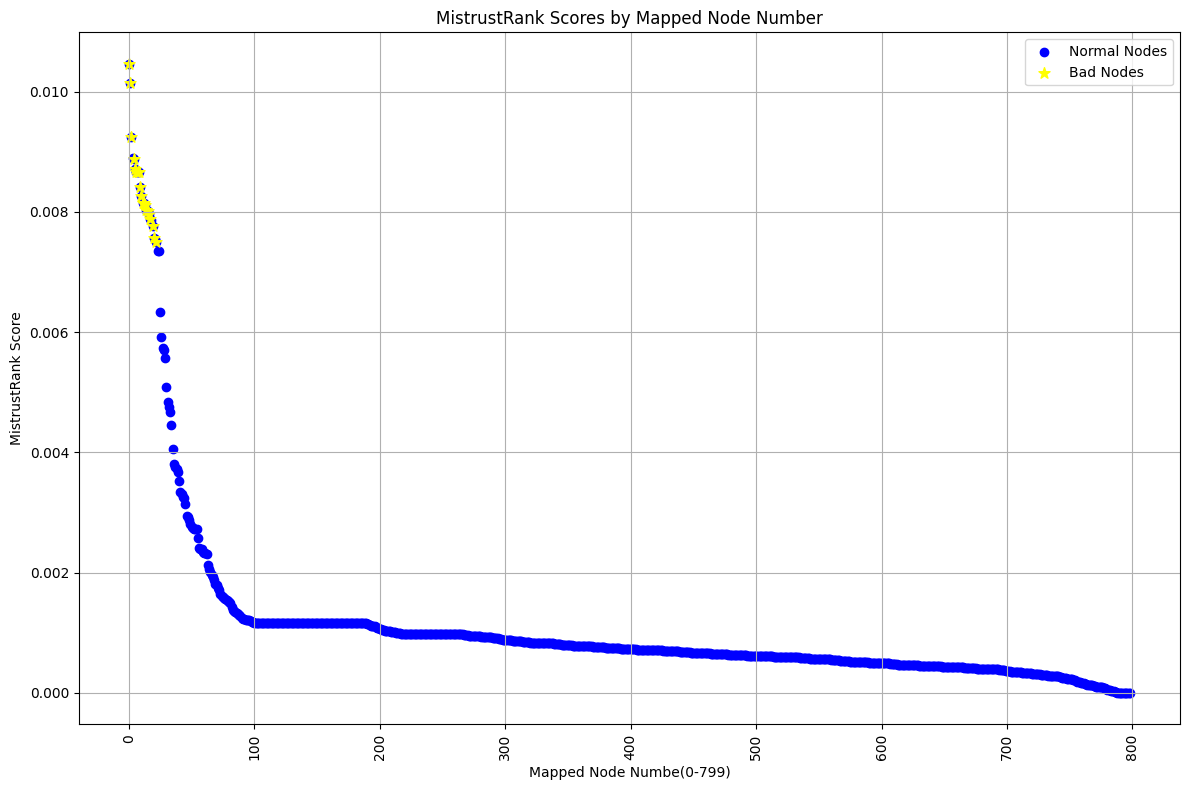

In [28]:
# First, sort the DataFrame by MistrustRank scores if not already sorted
mistrust_rank_df.sort_values(by='MistrustRank', ascending=False, inplace=True)

# Reset the index after sorting to get a new sequential order
mistrust_rank_df.reset_index(drop=True, inplace=True)

# Create a new column for mapped node numbers
mistrust_rank_df['Mapped Node'] = mistrust_rank_df.index  # This assigns a new sequential number to each node

# Create the plot
plt.figure(figsize=(12, 8))

# Scatter plot for all nodes
plt.scatter(mistrust_rank_df.index, mistrust_rank_df['MistrustRank'], color='blue', label='Normal Nodes')

# Scatter plot for bad nodes (diamond shape)
bad_nodes_indices = [idx for idx, node_id in enumerate(mistrust_rank_df['Node']) if node_id in g.bad_nodes]
plt.scatter(bad_nodes_indices, mistrust_rank_df.loc[bad_nodes_indices, 'MistrustRank'], color='yellow', s=70, marker='*', label='Bad Nodes')

plt.xlabel('Mapped Node Numbe(0-799)')
plt.ylabel('MistrustRank Score')
plt.title('MistrustRank Scores by Mapped Node Number')
plt.xticks(rotation=90)  # Rotates the x-axis labels to prevent overlap, might need adjustment based on actual node labels
plt.grid(True)  # Adds a grid for easier readability
plt.legend()  # Adds a legend to identify the plot elements
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits into the figure area.

# Show the plot
plt.show()



ANALYSIS:

The code takes a directed graph as input and computes the scores for each node in the graph. The output of the algorithm is a list of DistrustRank scores, one for each node in the graph.While there is no ground-truth data available for us to compare our results against, we can check the ranks of the oracle provided bad node which must be high if the algorithm worked perfectly.

RESULT:

From the plot above we can see that the majority of the ground-truth bad nodes have a higher scores(annotated in yellow *). This shows that the algorithm has worked as intended. Also, it is to be noted that no normal node has scored higher than all of the bad_nodes to achieve highest Mistrust rank score which showcases expected behaviour of the designed algorithm.

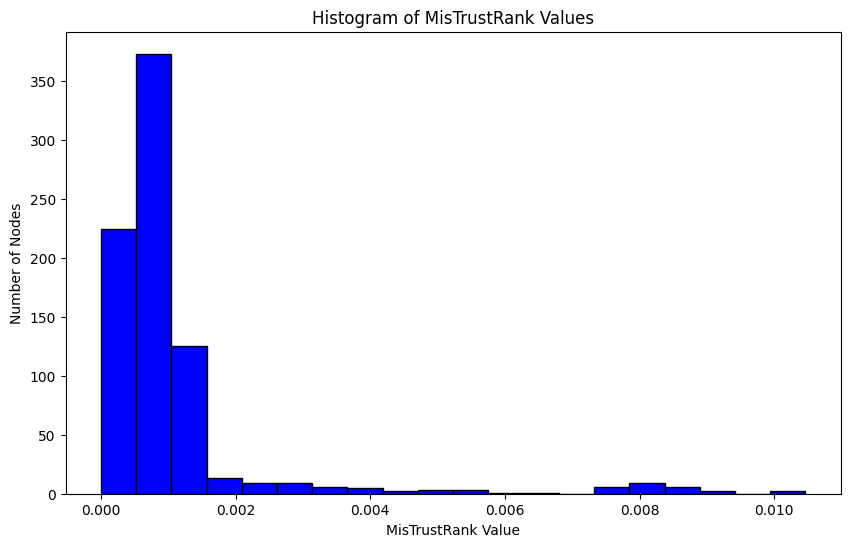

In [29]:

# Assuming 'trust_rank_df' is already defined and contains the TrustRank scores
# It's beneficial for the histogram to use all values without sorting or altering the dataset

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(mistrust_rank_df['MistrustRank'], bins=20, color='blue', edgecolor='black')

# Add titles and labels
plt.title('Histogram of MisTrustRank Values')
plt.xlabel('MisTrustRank Value')
plt.ylabel('Number of Nodes')

# Show the plot
plt.show()


ANALYSIS:
The above plot shows that most of the nodes have ranks between 0.00 and 0.01 while a few nodes have higher ranks indicating that the majority of the nodes are good nodes excluding a specific few.

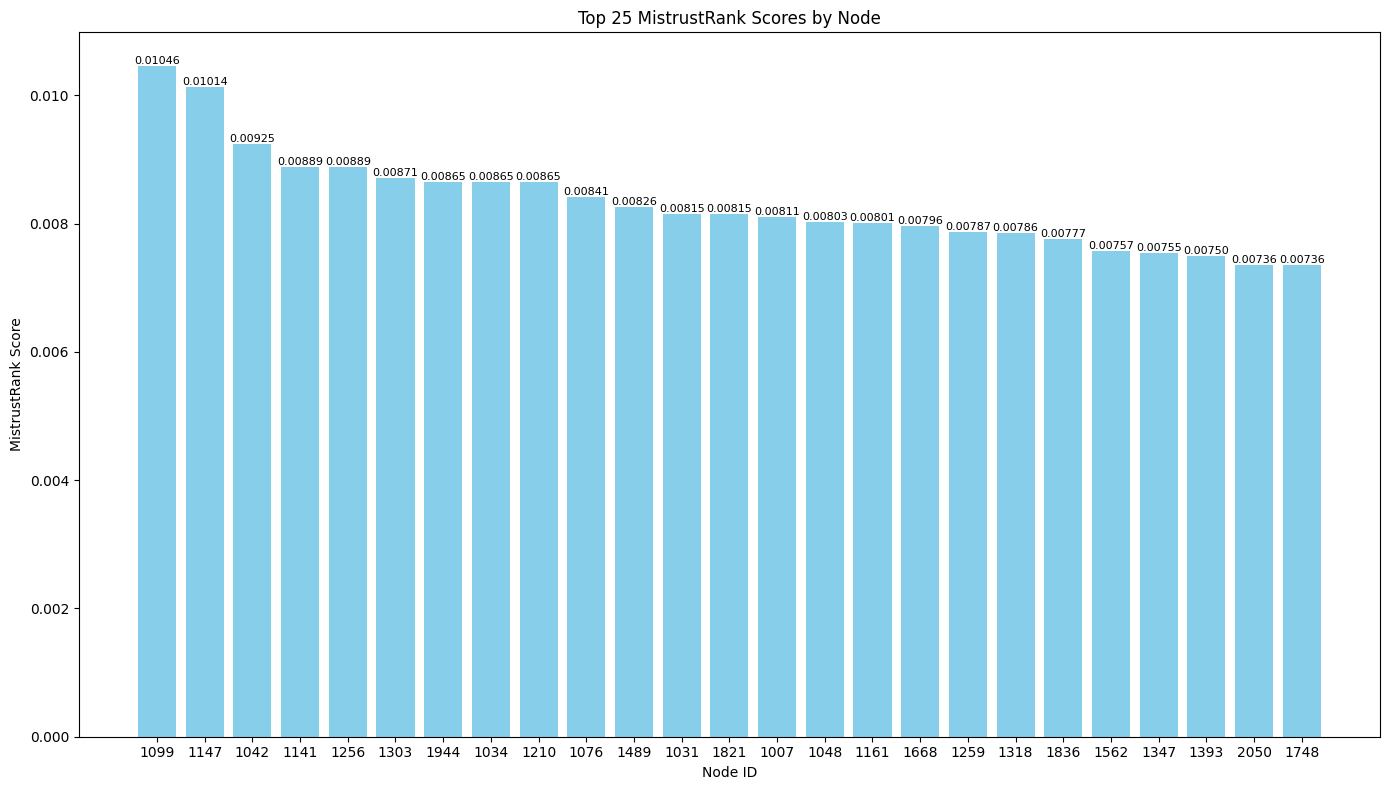

In [30]:
import matplotlib.pyplot as plt

# Assuming trust_rank_df is prepared and contains TrustRank scores along with their node IDs
# Sort the DataFrame by TrustRank in descending order and select the top 20 entries
top_20_trust_ranks = mistrust_rank_df.sort_values(by='MistrustRank', ascending=False).head(25)

# Create a bar plot
plt.figure(figsize=(14, 8))  # Set the figure size for better readability
# Use a range of numbers as the x-axis to ensure bars are equidistant
x = range(len(top_20_trust_ranks))
bars = plt.bar(x, top_20_trust_ranks['MistrustRank'], color='skyblue')

# Adding title and labels
plt.title('Top 25 MistrustRank Scores by Node')
plt.xlabel('Node ID')
plt.ylabel('MistrustRank Score')

# Set x-ticks to be the node IDs and ensure they are properly labeled
plt.xticks(x, top_20_trust_ranks['Node'], rotation=0)

# Optionally add value labels on each bar for clarity
for bar in bars:
    yval = bar.get_height()
    # Format the TrustRank score to five decimal places
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.5f}', ha='center', va='bottom', size =8)

# Adjust layout to not cut off labels
plt.tight_layout()

# Show the plot
plt.show()


**ANALYSIS**:
Out of Top 25 nodes with highest Mistrust value 20 seed bad sender nodes are found to be falling within Top-22 bad nodes. This is as expected and further proves that our algorithm is working a intended.